In [9]:
! pip install rdkit

     ---------------------------------------- 21.0/21.0 MB 2.2 MB/s eta 0:00:00


In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('butyrylcholinesterase_03_bioactivity_data_curated.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,920.00,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,900.00,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.00,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,1000.00,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,200.00,active
...,...,...,...,...
3767,CHEMBL5220093,COc1ccc(NC(=O)Oc2ccc3c(c2)[C@]2(O)CCN(C(C)=O)[...,2310.00,intermediate
3768,CHEMBL5218447,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...,6.42,active
3769,CHEMBL5220375,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...,34.90,active
3770,CHEMBL5218952,C#CCN1CCC(CCc2cccc(OC(=O)N(C)CC)c2)CC1,4300.00,intermediate


In [4]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [5]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [6]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,920.00,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,900.00,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.00,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,1000.00,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,200.00,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
3767,CHEMBL5220093,2310.00,intermediate,COc1ccc(NC(=O)Oc2ccc3c(c2)[C@]2(O)CCN(C(C)=O)[...
3768,CHEMBL5218447,6.42,active,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...
3769,CHEMBL5220375,34.90,active,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...
3770,CHEMBL5218952,4300.00,intermediate,C#CCN1CCC(CCc2cccc(OC(=O)N(C)CC)c2)CC1


#### Calculate Lipinski descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

In [10]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [11]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [12]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
3767,383.404,2.4975,3.0,6.0
3768,450.535,4.7249,1.0,6.0
3769,464.562,5.1150,1.0,6.0
3770,328.456,3.4149,0.0,3.0


In [13]:
df_combined = pd.concat([df,df_lipinski], axis=1)

#### Convert IC50 to pIC50

To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

* Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10
* Take the molar value and apply -log10
* Delete the standard_value column and create a new pIC50 column

In [14]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [15]:
df_combined.standard_value.describe()

count    3.772000e+03
mean     5.418085e+12
std      3.037956e+14
min      0.000000e+00
25%      2.010000e+02
50%      3.500000e+03
75%      2.208250e+04
max      1.862087e+16
Name: standard_value, dtype: float64

In [16]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [17]:
df_norm = norm_value(df_combined)
df_norm

C:\Users\User\AppData\Local\Temp\ipykernel_16060\3416609517.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,920.00
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,900.00
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,50000.00
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,1000.00
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,200.00
...,...,...,...,...,...,...,...,...
3767,CHEMBL5220093,COc1ccc(NC(=O)Oc2ccc3c(c2)[C@]2(O)CCN(C(C)=O)[...,intermediate,383.404,2.4975,3.0,6.0,2310.00
3768,CHEMBL5218447,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...,active,450.535,4.7249,1.0,6.0,6.42
3769,CHEMBL5220375,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...,active,464.562,5.1150,1.0,6.0,34.90
3770,CHEMBL5218952,C#CCN1CCC(CCc2cccc(OC(=O)N(C)CC)c2)CC1,intermediate,328.456,3.4149,0.0,3.0,4300.00


In [19]:
df_final = pIC50(df_norm)
df_final

C:\Users\User\AppData\Local\Temp\ipykernel_16060\3442786292.py:10: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))
C:\Users\User\AppData\Local\Temp\ipykernel_16060\3442786292.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.036212
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,6.045757
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.000000
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.698970
...,...,...,...,...,...,...,...,...
3767,CHEMBL5220093,COc1ccc(NC(=O)Oc2ccc3c(c2)[C@]2(O)CCN(C(C)=O)[...,intermediate,383.404,2.4975,3.0,6.0,5.636388
3768,CHEMBL5218447,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...,active,450.535,4.7249,1.0,6.0,8.192465
3769,CHEMBL5220375,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...,active,464.562,5.1150,1.0,6.0,7.457175
3770,CHEMBL5218952,C#CCN1CCC(CCc2cccc(OC(=O)N(C)CC)c2)CC1,intermediate,328.456,3.4149,0.0,3.0,5.366532


In [21]:
df_final.to_csv('butyrylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

In [22]:
# remove 'intermediate' bioactivity
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.036212
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,6.045757
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.000000
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.698970
...,...,...,...,...,...,...,...,...
3764,CHEMBL5219771,CNC(=O)Oc1cccc(CN(C)CCCCCCCOc2cccc(-c3cc(=O)c4...,active,528.649,6.6395,1.0,6.0,7.195861
3765,CHEMBL2047525,CNC(=O)Oc1cccc(CN(C)CCCCCCCOc2ccc(-c3cc4ccccc4...,active,528.649,6.6395,1.0,6.0,7.226214
3766,CHEMBL5218931,CC(=O)N1CC[C@@]2(O)c3cc(OC(=O)Nc4ccccc4)ccc3N[...,inactive,353.378,2.4889,3.0,5.0,4.000000
3768,CHEMBL5218447,CN(CCCOc1ccc2ccc(=O)oc2c1)Cc1cccc(OC(=O)NC2CCC...,active,450.535,4.7249,1.0,6.0,8.192465


In [23]:
df_2class.to_csv('butyrylcholinesterase_05_bioactivity_data_2class_pIC50.csv')

#### Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors

In [24]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

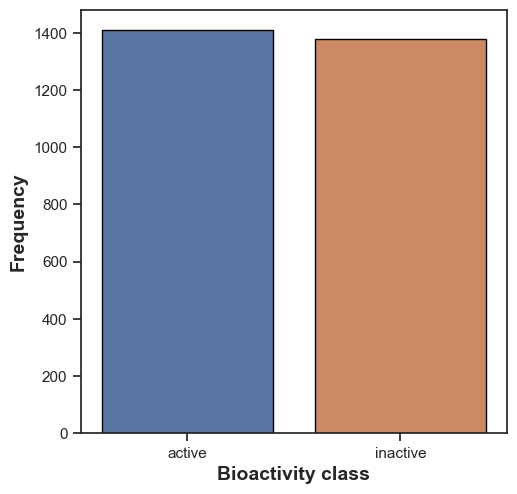

In [25]:
# Frequency plot of the 2 bioactivity classes

plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

Text(0, 0.5, 'pIC50 value')

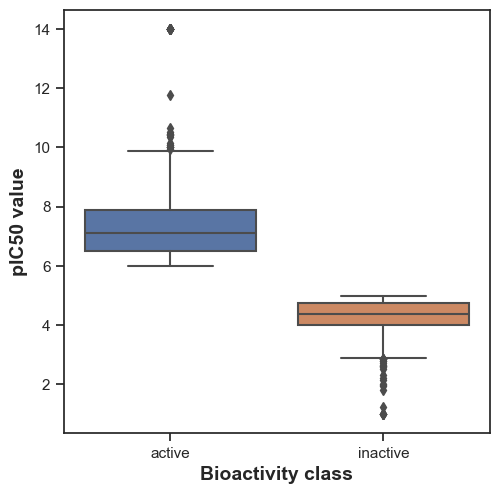

In [32]:
# pIC50 value

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

In [33]:
# Statistical analysis | Mann-Whitney U Test


def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results
     

mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1944390.0,0.0,0.05,Different distribution (reject H0)


Text(0, 0.5, 'MW')

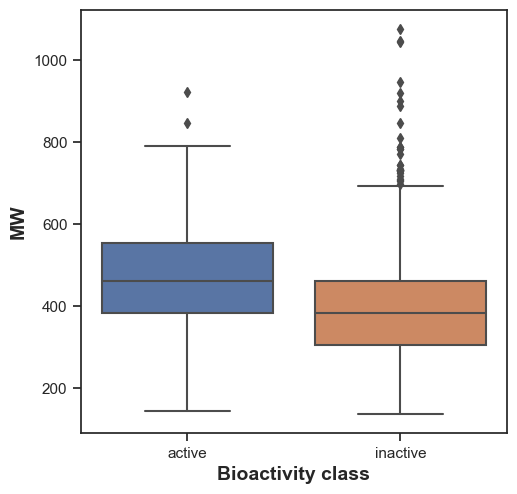

In [34]:
# MW

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

Text(0, 0.5, 'LogP')

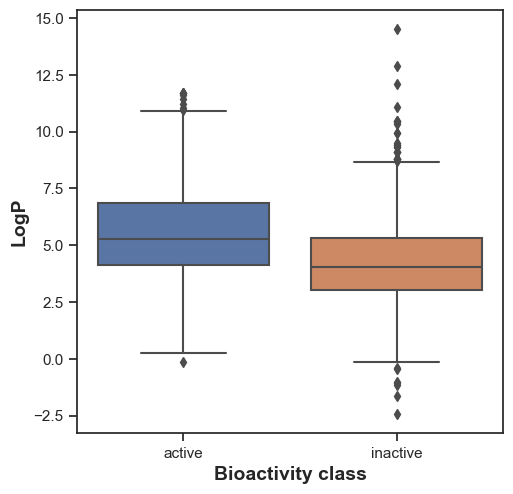

In [36]:
# LogP

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

In [37]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1322758.0,4.491067e-61,0.05,Different distribution (reject H0)


Text(0, 0.5, 'NumHDonors')

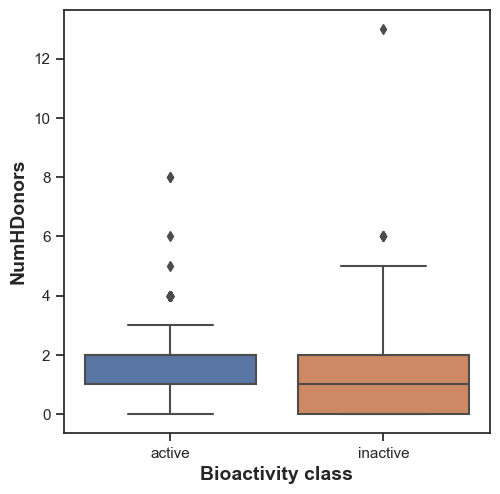

In [38]:
# NumHDonors

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

In [39]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1335420.5,2.156527e-70,0.05,Different distribution (reject H0)


Text(0, 0.5, 'NumHAcceptors')

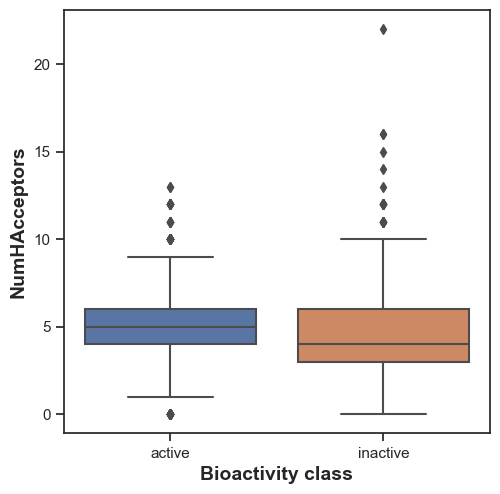

In [40]:
# NumHAcceptors

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

In [41]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1048973.5,0.000258,0.05,Different distribution (reject H0)
